2024-06-22 11:51:01.916 
  command:

    streamlit run C:\Users\User\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


   call IV   call OI  % change oi   strike  % change oi put    put OI  put IV
0     5.13   10744.0       115.83  23350.0             7.76   35191.0   13.20
1     6.33   91019.0        64.86  23400.0            25.81  152399.0   13.19
2     6.97   46132.0       212.65  23450.0            66.97   47386.0   13.39
3     7.38  231329.0        37.05  23500.0            -5.73  207890.0   13.66
4     7.82   74705.0       140.42  23550.0             9.02   35563.0   14.07
5     8.11  221544.0        40.87  23600.0           -24.85   88377.0   14.33
6     8.35   83555.0       155.15  23650.0            82.57   15931.0   14.90
   call IV   call OI  % change oi   strike  % change oi put    put OI  put IV
0     5.13   10744.0       115.83  23350.0             7.76   35191.0   13.20
1     6.33   91019.0        64.86  23400.0            25.81  152399.0   13.19
2     6.97   46132.0       212.65  23450.0            66.97   47386.0   13.39
3     7.38  231329.0        37.05  23500.0            -5.73  207

   call IV   call OI  % change oi   strike  % change oi put    put OI  put IV
0     5.13   10744.0       115.83  23350.0             7.76   35191.0   13.20
1     6.33   91019.0        64.86  23400.0            25.81  152399.0   13.19
2     6.97   46132.0       212.65  23450.0            66.97   47386.0   13.39
3     7.38  231329.0        37.05  23500.0            -5.73  207890.0   13.66
4     7.82   74705.0       140.42  23550.0             9.02   35563.0   14.07
5     8.11  221544.0        40.87  23600.0           -24.85   88377.0   14.33
6     8.35   83555.0       155.15  23650.0            82.57   15931.0   14.90
   call IV   call OI  % change oi   strike  % change oi put    put OI  put IV
0     5.13   10744.0       115.83  23350.0             7.76   35191.0   13.20
1     6.33   91019.0        64.86  23400.0            25.81  152399.0   13.19
2     6.97   46132.0       212.65  23450.0            66.97   47386.0   13.39
3     7.38  231329.0        37.05  23500.0            -5.73  207

KeyboardInterrupt: 

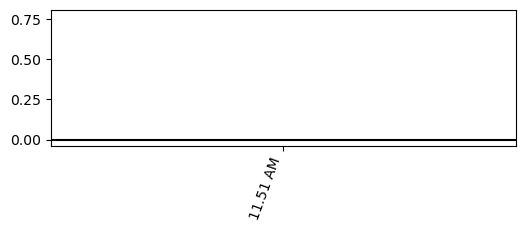

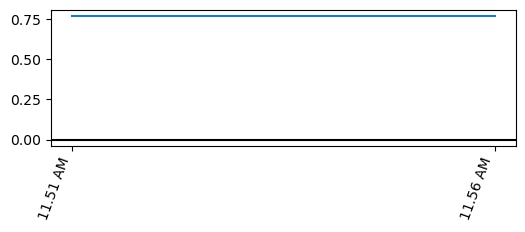

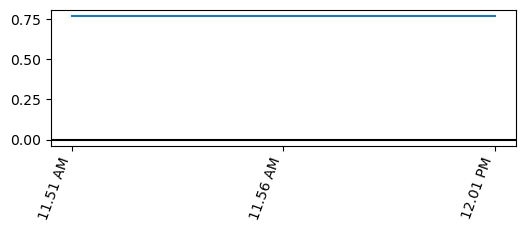

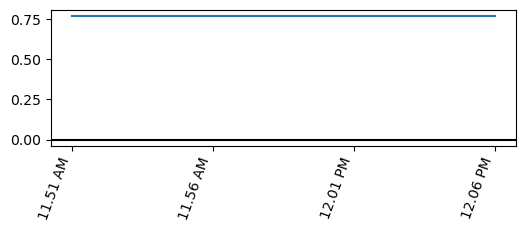

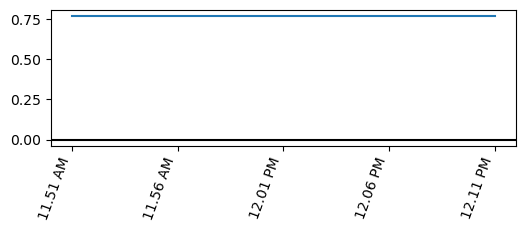

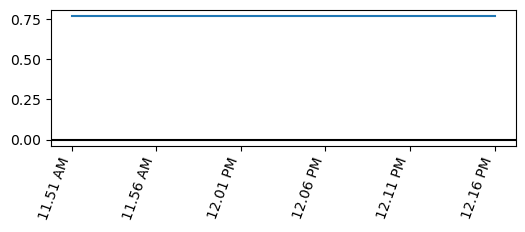

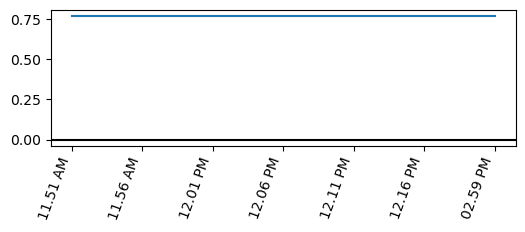

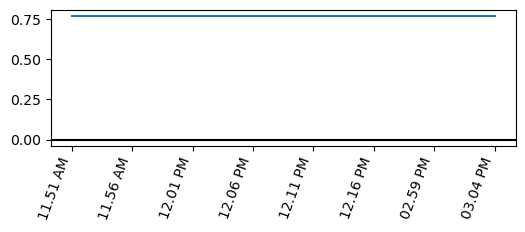

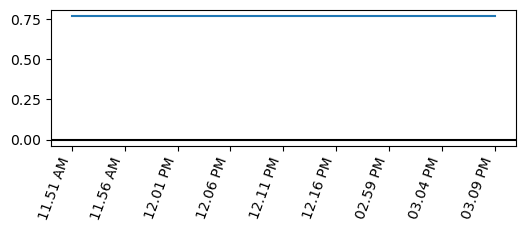

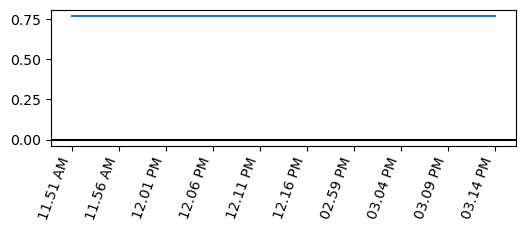

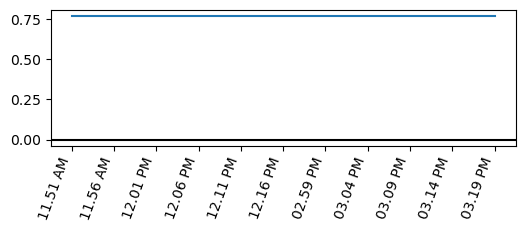

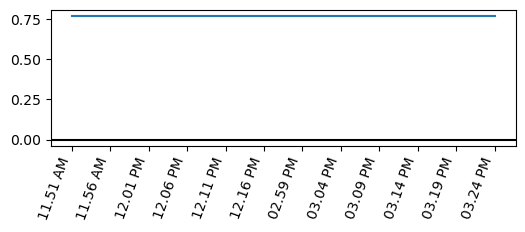

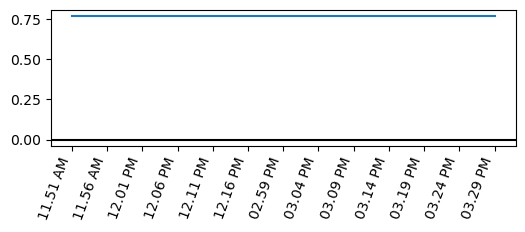

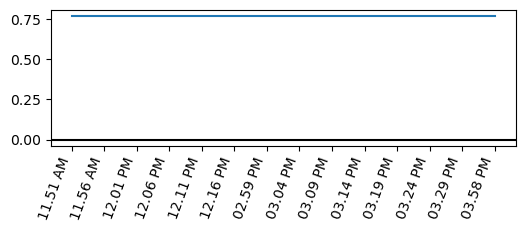

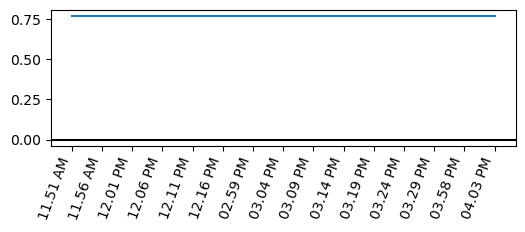

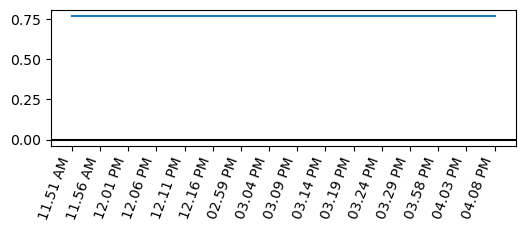

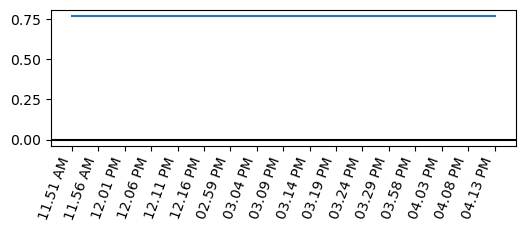

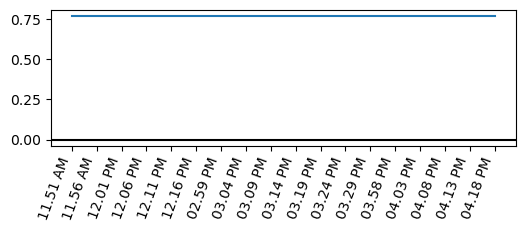

In [3]:
from nsepythonserver import *
import seaborn as sns
import pandas as pd
import streamlit as st
from datetime import datetime
from time import gmtime, strftime
# from IPython.display import clear_output 
import matplotlib.pyplot as plt
from pytz import timezone 
from deta import Deta
import plotly.express as px


def get_data():
    while True:
        try:
            data=nse_fno("NIFTY")
            last_prices=round(nse_quote_ltp("NIFTY"))
            break
        except:
            time.sleep(1)
    expiry=list(set(data['expiryDates']))
    expiry.sort(key = lambda date: datetime.strptime(date, '%d-%b-%Y'))
    if last_prices%100>50:
        x=(last_prices-last_prices%100+50)
        strike=sorted([x-150,x-100,x-50,x,x+50,x+100,x+150])
    elif last_prices%100<=50:
        x=(last_prices-last_prices%100)
        strike=sorted([x-150,x-100,x-50,x,x+50,x+100,x+150])
    d={'call IV':[],
        'call OI':[],
        '% change oi':[],
        'strike':[],
         '% change oi put':[],
        'put OI':[],
        'put IV':[],
         } 
    for nifty_strike in strike: 
        for i in data['stocks']:
        
            if i['metadata']['expiryDate']==expiry[0] and i['metadata']['optionType']=='Call' and i['metadata']['strikePrice']==nifty_strike:
                d['strike'].append(nifty_strike)
                d['call OI'].append(i['marketDeptOrderBook']['tradeInfo']['openInterest'])
                d['% change oi'].append(i['marketDeptOrderBook']['tradeInfo']['pchangeinOpenInterest'])
                d['call IV'].append(i['marketDeptOrderBook']['otherInfo']['impliedVolatility'])
            if i['metadata']['expiryDate']==expiry[0] and i['metadata']['optionType']=='Put' and i['metadata']['strikePrice']==nifty_strike:
                d['put OI'].append(i['marketDeptOrderBook']['tradeInfo']['openInterest'])
                d['% change oi put'].append(i['marketDeptOrderBook']['tradeInfo']['pchangeinOpenInterest'])
                d['put IV'].append(i['marketDeptOrderBook']['otherInfo']['impliedVolatility'])
    out=pd.json_normalize(d)
    out.fillna(0,inplace=True)
    try:
        out=out.explode(list(out.columns)).reset_index(drop=True)
    except:
        def pad_dict_list(dict_list, padel):
            lmax = 0
            for lname in dict_list.keys():
                lmax = max(lmax, len(dict_list[lname]))
            for lname in dict_list.keys():
                ll = len(dict_list[lname])
                if  ll < lmax:
                    dict_list[lname] += [padel] * (lmax - ll)
            return dict_list
        out = pad_dict_list(d, 0)
        out=pd.DataFrame(out)
        out.set_index(list(out.columns)).apply(pd.Series.explode).reset_index()
    
    x=out.astype(float).round(2)
    x.sort_values("strike", axis = 0, ascending = True,inplace = True)
    return x
def get_info(dataset):
    df= pd.DataFrame(columns=[ 'pcr', 'cal_per','put_per'])
    value= dataset['put OI'].sum() - dataset['call OI'].sum()
    pcr= dataset['put OI'].sum()/dataset['call OI'].sum()
    cal_per= dataset['% change oi'].mean()
    put_per= dataset['% change oi put'].mean()
    # dirn=dataset['% change oi put']-dataset['% change oi']
    new_row={'time':datetime.now(timezone("Asia/Kolkata")).strftime('%I.%M %p'),'Diffn':round(value,2) ,'pcr':round(pcr,2), 'cal_per':round(cal_per,2), 'put_per':round(put_per,2)}
    df=pd.DataFrame(new_row,index=[0])
    putt,calll=abs(df['put_per'].tail(1).values),abs(df['cal_per'].tail(1).values)
    df['dirn']=putt-calll
    return df  


def ploting():
        try:
            global final
        except:
             df = pd.DataFrame(columns=['Diffn', 'pcr', 'cal_per','put_per'])
        dataset= get_data()
        main= get_info(dataset)
        main1=main[['Diffn', 'pcr', 'cal_per','put_per','time','dirn']]
        final=pd.concat([final,main1],ignore_index=True)
        
        return dataset,final

if __name__=='__main__':
    
    st.title('WELCOME BULLS CARTEL')
    st.header('WELCOME TO NIFTY 50')
    today_date =strftime("%d %b %Y", gmtime()),datetime.now(timezone("Asia/Kolkata")).strftime('%I.%M %p')
    st.markdown(f"as at {today_date}")
    option= st.selectbox(
    'How would you like to be contacted?',
    ('5', '10', '15')) 
    st.write('You selected:', option)
    st.markdown('Important Information')
    st.markdown(""" CALL % INCREASE MEANS MARKET GOES DOWN  
             PUT % INCREASE MEANS MARKET GOES UP
             """)    
final = pd.DataFrame(columns=['Diffn', 'pcr', 'cal_per','put_per','time','dirn'])

while True:
    dataset,final=ploting()      
    print(dataset)
    p1=st.empty()
    p2=st.empty()
    p3=st.empty()
    p4=st.empty()
             # % change oi put

    values,values1, v=dataset['call OI'], dataset['put OI'],dataset['strike']
    # print(values,values1 , v)
    
    
    result1 = dict(sorted(list(map(lambda x: (v.loc[values.loc[values ==x].index[0]],round((x / sum(values)) * 100)), values)),key=lambda x:x[1],reverse=True))
    result2 = dict(sorted(list(map(lambda x: (v[values1.loc[values1 ==x].index[0]],round((x / sum(values1)) * 100)), values1)),key=lambda x:x[1],reverse=True))
    call=pd.DataFrame(zip(['call']*6,list(result1.values()),list(zip(list(result1.values()),list(result1.keys())))))
    put=pd.DataFrame(zip(['put']*6,list(result2.values()),list(zip(list(result2.values()),list(result1.keys())))))
    d=pd.concat([call,put],ignore_index=True)

    fig =px.bar(d,x =0,y=1,text=1,color=2, title='Open Interest Chart', barmode='group')

    p4.plotly_chart(fig,height=400, key="unique_key")

    p1.dataframe(dataset.style.highlight_max(['% change oi put','% change oi'],axis=0)) #Column hightlight 
    p2.dataframe(final.style.highlight_max(['cal_per','put_per'],axis=1)) # row highlight
    fig, ax = plt.subplots(figsize=(6, 2)) 
    ax.plot(final['time'],final['pcr'])
    ax.axhline(y=0, color='black', linestyle='solid') # 0 line graph
    fig.autofmt_xdate(rotation=70)
    p3.pyplot(fig)
    time.sleep(5*60) # how to the start again code check upper condition min * sec
    p1.empty() # then clean all data frame 
    p2.empty()
    p3.empty()
    p4.empty()

In [2]:
!pip install deta

  Obtaining dependency information for deta from https://files.pythonhosted.org/packages/fa/70/e742f03eaf8bd782c897fc115379341a94d53b9616f1fa9d1345ab14b1da/deta-1.2.0-py3-none-any.whl.metadata
